[View in Colaboratory](https://colab.research.google.com/github/nifred/Champypy/blob/master/Keras_champypy_inceptionV3.ipynb)

# Champypy CNN Training script

## Making train, validation and test sets

Using pandas and sklearn model selection train test split.


In [1]:
import keras

Using TensorFlow backend.


Mount a google drive with the dataset in pickle format on

In [2]:
from google.colab import drive
drive.mount('/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code
Enter your authorization code:
··········
Mounted at /gdrive


In [0]:
import pandas as pd
from sklearn.model_selection import train_test_split

Reading the dataset.

In [0]:
dataset = pd.read_pickle('/gdrive/My Drive/dataSet_x500.data')


Splitting features and target in two data sets.

In [0]:
target = dataset.loc[:,'classes']
dataset.drop('classes', axis=1, inplace=True)

Train set 72 % of the dataset.

Validation set 8% of the dataset.

Test set 20 % of the dataset.

In [0]:
X_train, X_test, y_train, y_test = train_test_split(dataset, target, test_size=0.20, stratify=target)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.10, stratify=y_train)

### Showing random pictures

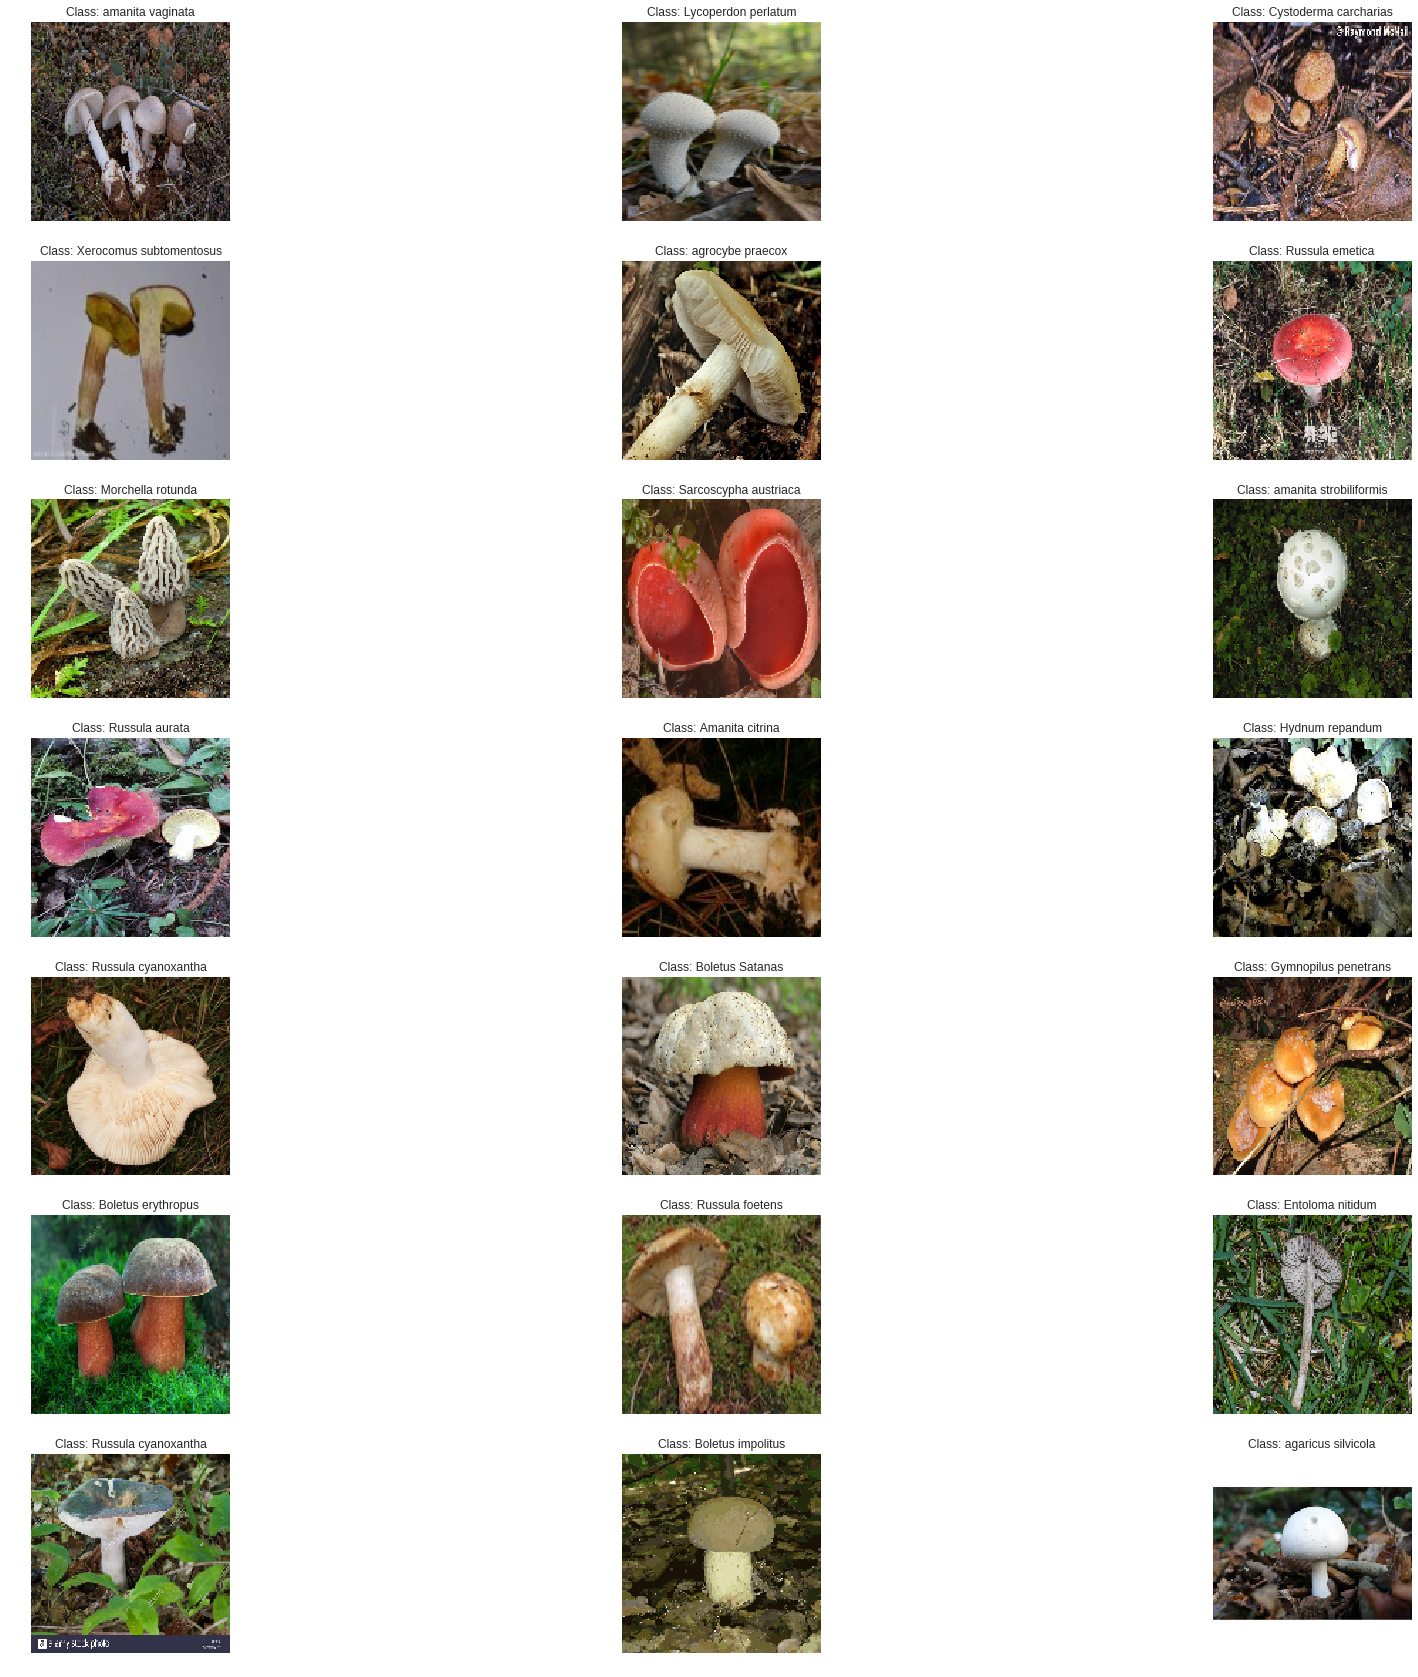

In [69]:
from matplotlib import cm
j=0
plt.figure(figsize=(30,30))
for i in np.random.choice(len(dataset), size=21) :
    j=j+1
    img = np.asarray(dataset.iloc[i,:])
    img = img.reshape(140,140,3)
    
    plt.subplot(7,3,j)
    plt.axis('off')
    plt.imshow(img,cmap = cm.binary)
    plt.title('Class: {}'.format(target[i], fontsize=18))

### Distribution of mushroom classes

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


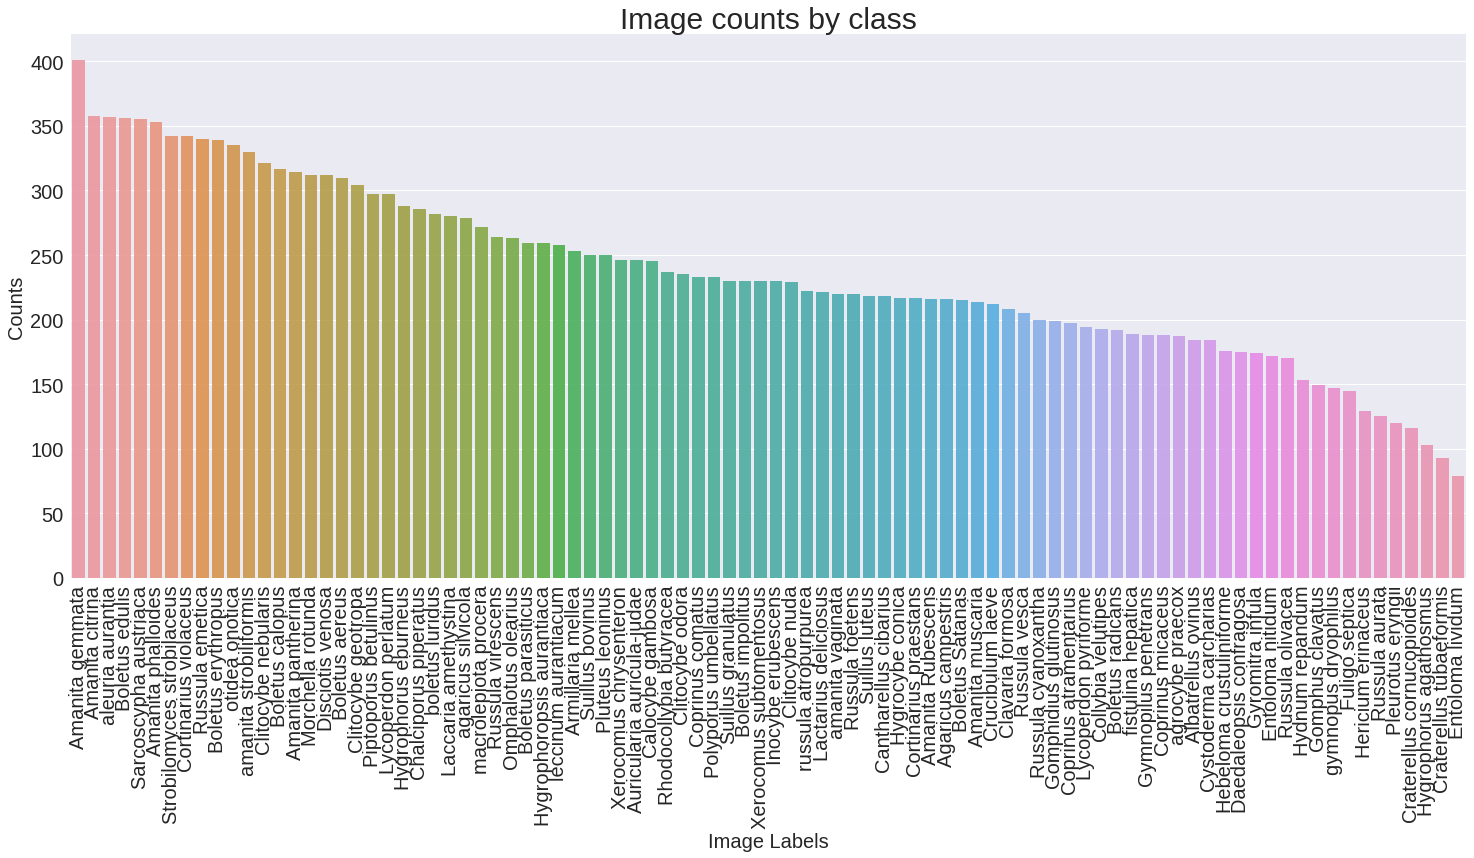

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
label_counts = target.value_counts()
plt.figure(figsize = (25,10))
sns.barplot(label_counts.index, label_counts.values, alpha = 0.9)
plt.xticks(rotation = 'vertical')
plt.xlabel('Image Labels', fontsize =20)
plt.ylabel('Counts', fontsize = 20)
plt.title('Image counts by class', fontsize=30)
plt.tick_params(axis = 'both', which = 'major', labelsize = 20)
plt.show();

## Transforming train, validation, test sets for model training

In [0]:
import numpy as np

Transforming data sets in numpy arrays

In [0]:
X_train = np.asarray(X_train)
X_test = np.asarray(X_test)
X_val = np.asarray(X_val)

Reshaping data sets in a series of pictures of from 58800px to 140x140x3

In [0]:
X_train = X_train.reshape(X_train.shape[0], 140, 140, 3)
X_test = X_test.reshape(X_test.shape[0], 140, 140, 3)
X_val = X_val.reshape(X_val.shape[0], 140, 140, 3)

Encoding string labels to integer labels

In [0]:
from sklearn.preprocessing import LabelEncoder

In [0]:
encoder = LabelEncoder()
y_train = encoder.fit_transform(np.asarray(y_train))
y_test = encoder.transform(np.asarray(y_test))
y_val = encoder.transform(np.asarray(y_val))

One hot encoding the integer labels

In [0]:
from keras.utils import to_categorical
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)
y_val = to_categorical(y_val)

## CNN Model

Making an Image data generator to flow datas inside the model

In [0]:
from keras.preprocessing.image import ImageDataGenerator
datagen = ImageDataGenerator(
    featurewise_center=False,
    featurewise_std_normalization=False,
    rescale=1./255,
    data_format="channels_last")

Fitting the image data generator to the train set

In [0]:
datagen.fit(X_train)

In [0]:
train_datagen = datagen.flow(X_train, y_train, batch_size=32)
val_datagen = datagen.flow(X_val, y_val, batch_size=32)
test_datagen = datagen.flow(X_test, y_test, batch_size=32)

In [0]:
from keras.applications import InceptionV3
from keras.models import Model
from keras.layers import Dense, Input, Dropout, Flatten, AveragePooling2D
from keras.callbacks import ModelCheckpoint, CSVLogger, EarlyStopping, LearningRateScheduler
from keras.regularizers import l2
from keras.optimizers import SGD
import keras.backend as K

## Model

The base model is an InceptionV3 with ImageNet weights retrained with our dataset.
The last layers is made of an:


*  AveragePooling2D layer with a pool size of 3x3 to reduce the number of parameters
*  Dropout layer of 0.4 for preventing complex co-adaptations on training data.
*  Flatten layer to reshape the matrix
*  Dense layer of 90 classes with a [glorot uniform initializer](http://jmlr.org/proceedings/papers/v9/glorot10a/glorot10a.pdf),  an l2 of 0.05 biais regulizer to solve overfitting problem and a softmax activation

We are logging each epoch, and saving best weights on the Google drive.
Also we are using a learning rate scheduler to increase performance and avoid overfitting and an early stopping.



In [17]:
K.clear_session()


base_model = InceptionV3(
    weights='imagenet',
    include_top=False,
    input_tensor=Input(
        shape=(140, 140, 3)
    )
)


x = base_model.output
x = AveragePooling2D(pool_size=(3, 3))(x)
x = Dropout(.4)(x)
x = Flatten()(x)

predictions = Dense(
    90,
    kernel_initializer='glorot_uniform',
    bias_regularizer=l2(.05),
    activation='softmax')(x)

model = Model(
    inputs=base_model.input,
    outputs=predictions
)


opt = SGD(lr=.01, momentum=.9)
model.compile(
    optimizer=opt,
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

checkpointer = ModelCheckpoint(
    filepath='/gdrive/My Drive/Champypy_InceptionV3.1.{epoch:02d}-{val_loss:.2f}.hdf5',
    monitor='val_loss',
    verbose=1,
    save_best_only=True
)
csv_logger = CSVLogger(
    '/gdrive/My Drive/Champypy_InceptionV3.1.log'
)


def schedule(epoch):
    if epoch < 4:
        return .001
    elif epoch < 10:
        return .0002
    else:
        return .00004
      
lr_scheduler = LearningRateScheduler(schedule)
early_stopping = EarlyStopping(monitor='val_loss',
                              min_delta=0,
                              patience=2,
                              verbose=0, mode='auto')
model.fit_generator(
    train_datagen,
    validation_data=val_datagen,
    steps_per_epoch=len(X_train) / 32,
    epochs=32,
    verbose=1,
    callbacks=[
        csv_logger,
        checkpointer,
        lr_scheduler,
        early_stopping
    ]
)



Epoch 1/32
480/479 [==============================] - 195s 407ms/step - loss: 3.7214 - acc: 0.1659 - val_loss: 2.9132 - val_acc: 0.3177

Epoch 00001: val_loss improved from inf to 2.91318, saving model to /gdrive/My Drive/Champypy_InceptionV3.1.01-2.91.hdf5
Epoch 2/32
480/479 [==============================] - 184s 383ms/step - loss: 2.2076 - acc: 0.4378 - val_loss: 1.9415 - val_acc: 0.4994

Epoch 00002: val_loss improved from 2.91318 to 1.94150, saving model to /gdrive/My Drive/Champypy_InceptionV3.1.02-1.94.hdf5
Epoch 3/32
480/479 [==============================] - 185s 385ms/step - loss: 1.4881 - acc: 0.6014 - val_loss: 1.7480 - val_acc: 0.5428

Epoch 00003: val_loss improved from 1.94150 to 1.74801, saving model to /gdrive/My Drive/Champypy_InceptionV3.1.03-1.75.hdf5
Epoch 4/32
480/479 [==============================] - 184s 384ms/step - loss: 1.0061 - acc: 0.7285 - val_loss: 1.6633 - val_acc: 0.5750

Epoch 00004: val_loss improved from 1.74801 to 1.66334, saving model to /gdrive/M

## Model train visualization

### Accuracy vs epoch

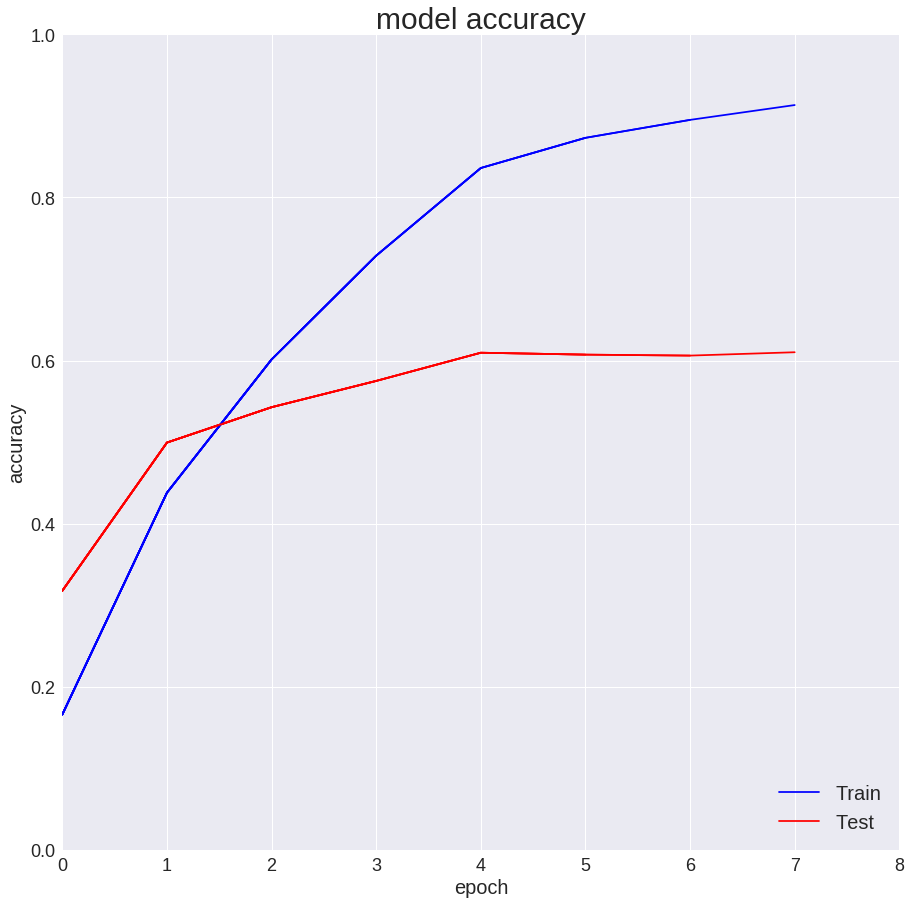

In [36]:
import time
import pylab as plt
from IPython import display

acc= model.history.history['acc']
val_acc= model.history.history['val_acc']

first_iteration = True 
plt.figure(figsize=(15,15))
for i in range(8):
    train_acc, = plt.plot(acc[:i+1], label='Train', color='blue')
    test_acc, = plt.plot(val_acc[:i+1], label='Test', color='red')
    
    if first_iteration :
        plt.axis([0,8,0.0,1.0])
        plt.title('model accuracy', fontsize=30)
        plt.ylabel('accuracy', fontsize=20)
        plt.xlabel('epoch', fontsize=20)
        plt.legend(handles=[train_acc, test_acc], loc=4, fontsize=20)
        plt.tick_params(axis = 'both', which = 'major', labelsize = 18)
        first_iteration = False
        
    display.clear_output(wait=True)
    display.display(plt.gcf())
    
    time.sleep(1.5)

display.clear_output()

### Cross entropy vs epoch

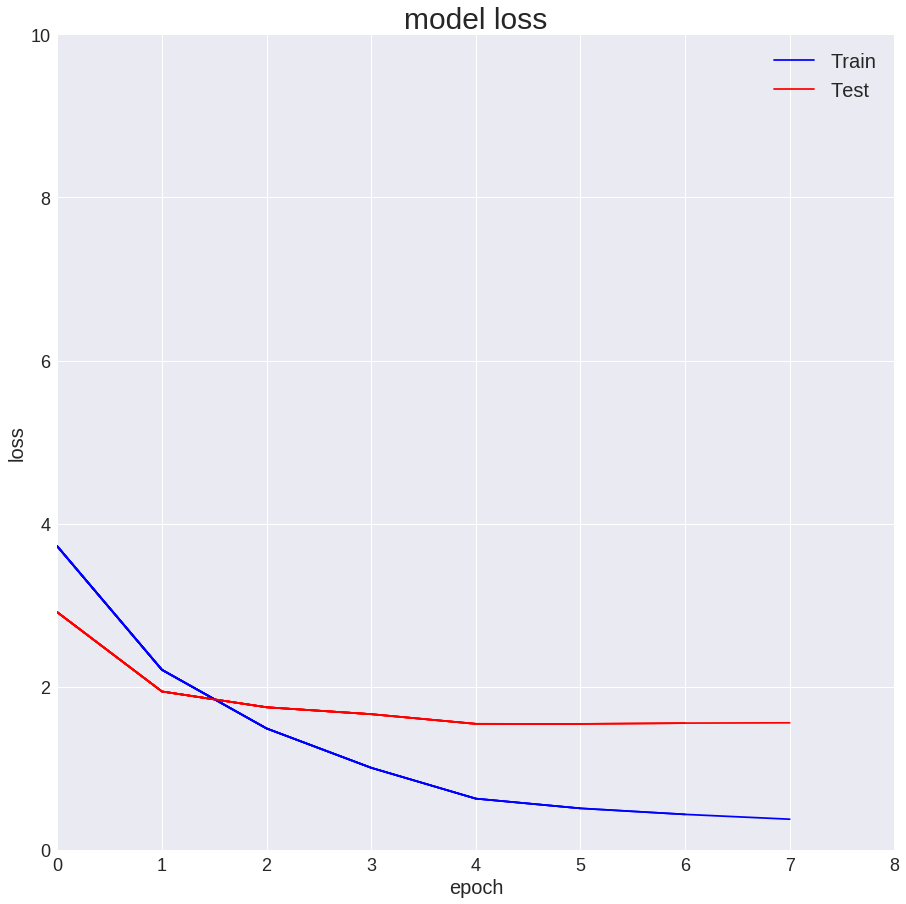

In [39]:
loss = model.history.history['loss']
val_loss = model.history.history['val_loss']

first_iteration = True 
plt.figure(figsize=(15,15))

for i in range(8):
    train_loss, = plt.plot(loss[:i+1], label= 'Train', color='blue')
    test_loss, = plt.plot(val_loss[:i+1], label= 'Test', color='red')
    
    if first_iteration:
        plt.axis([0,8,0,10])
        plt.title('model loss', fontsize=30)
        plt.ylabel('loss', fontsize=20)
        plt.xlabel('epoch', fontsize=20)
        plt.legend(handles=[train_loss, test_loss], loc='best', fontsize=20)
        plt.tick_params(axis = 'both', which = 'major', labelsize = 18)
        first_iteration = False
    
    display.clear_output(wait=True)
    display.display(plt.gcf())

    time.sleep(1.0)

display.clear_output()

## Visualizing layer outputs

We are using the keras-vis librairy where you can found here: https://github.com/raghakot/keras-vis

In [0]:
!pip install keras-vis

In [0]:
from vis.losses import ActivationMaximization
from vis.regularizers import TotalVariation, LPNorm
from vis.input_modifiers import Jitter
from vis.callbacks import GifGenerator

Making a dictionary of model layers.

In [0]:
layer_dict = dict([(layer.name, layer) for layer in model.layers])

Showing 3 activation layer outputs from begining, middle and last.

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


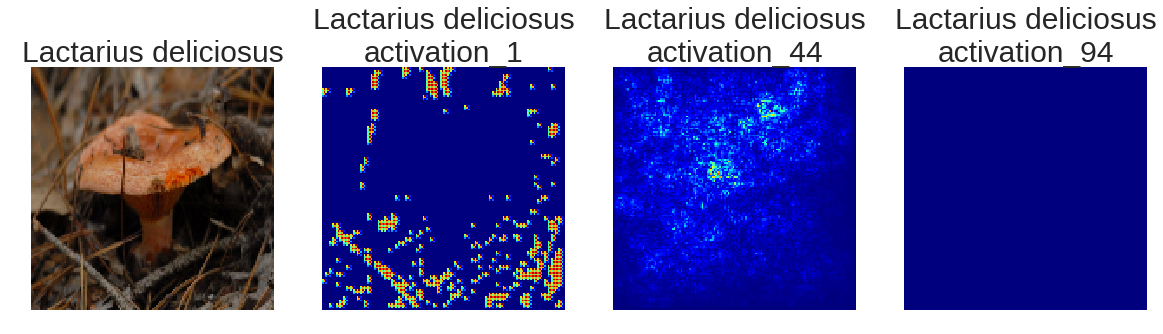

In [23]:
from vis.visualization import visualize_saliency, overlay
from vis.utils import utils
from keras import activations
import matplotlib.pyplot as plt
%matplotlib inline

def showing_layer_outputs(layer_input):
  layers = []
  for layer in layer_dict.keys():
    if layer.__contains__(layer_input):
      layers.append(layer)
    
  layer_idx = [utils.find_layer_idx(model, e) for e in sorted(layers)]
  middle = int(round(len(layers)/2))
  layer_selected = [layer_idx[0], layer_idx[middle], layer_idx[-1]]
  img1 = X_train[0]
  f, ax = plt.subplots(1, 4, figsize=(20,10))
  ax0_text = encoder.inverse_transform(np.argmax(y_train[0], axis=-1))
  ax[0].set_title(ax0_text, fontsize=30)
  ax[0].grid('off')
  ax[0].axis('off')
  ax[0].imshow(img1)
  i=1
  n = [0, middle, len(layer_idx)-1]
  j=0
  for layer in layer_selected:
    grads = visualize_saliency(model, layer, filter_indices=0, seed_input=img1)
    ax[i].set_title(ax0_text + "\n" + layers[n[j]], fontsize=30)
    ax[i].grid('off')
    ax[i].axis('off')
    ax[i].imshow(grads, cmap='jet')
    i +=1
    j +=1

showing_layer_outputs('activation')

Showing 3 conv2d layer outputs from begining, middle and last.

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


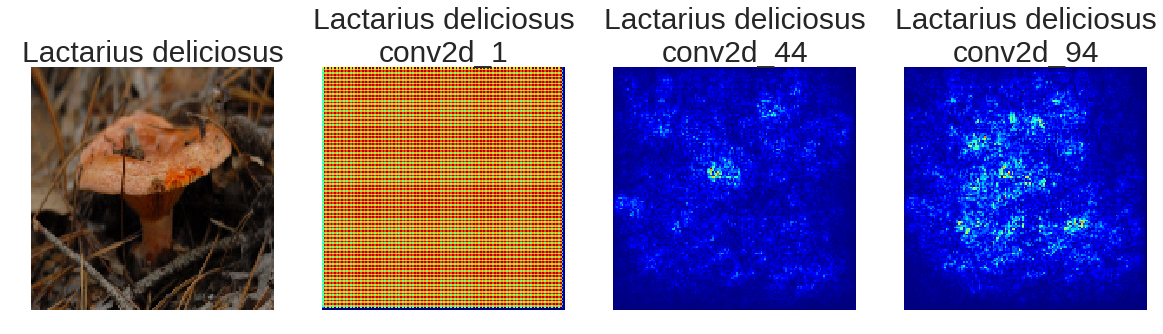

In [24]:
showing_layer_outputs('conv2d')

## Evaluation on test image data generator set

We got a 61% of accuracy with a 1.53 loss.

In [25]:
evaluation = model.evaluate_generator(test_datagen)
print(evaluation)

[1.5269060269082018, 0.6113977485928705]


## Prediction on test set

In [0]:
prediction = model.predict(X_test/255)


In [0]:
prediction_argmax = np.argmax(prediction, axis=-1)
y_test_argmax = np.argmax(y_test, axis=-1)

Getting the original label names

In [28]:
y_test_v = encoder.inverse_transform(y_test_argmax)
pred_v = encoder.inverse_transform(prediction_argmax)

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


### Visualizing confusion matrix

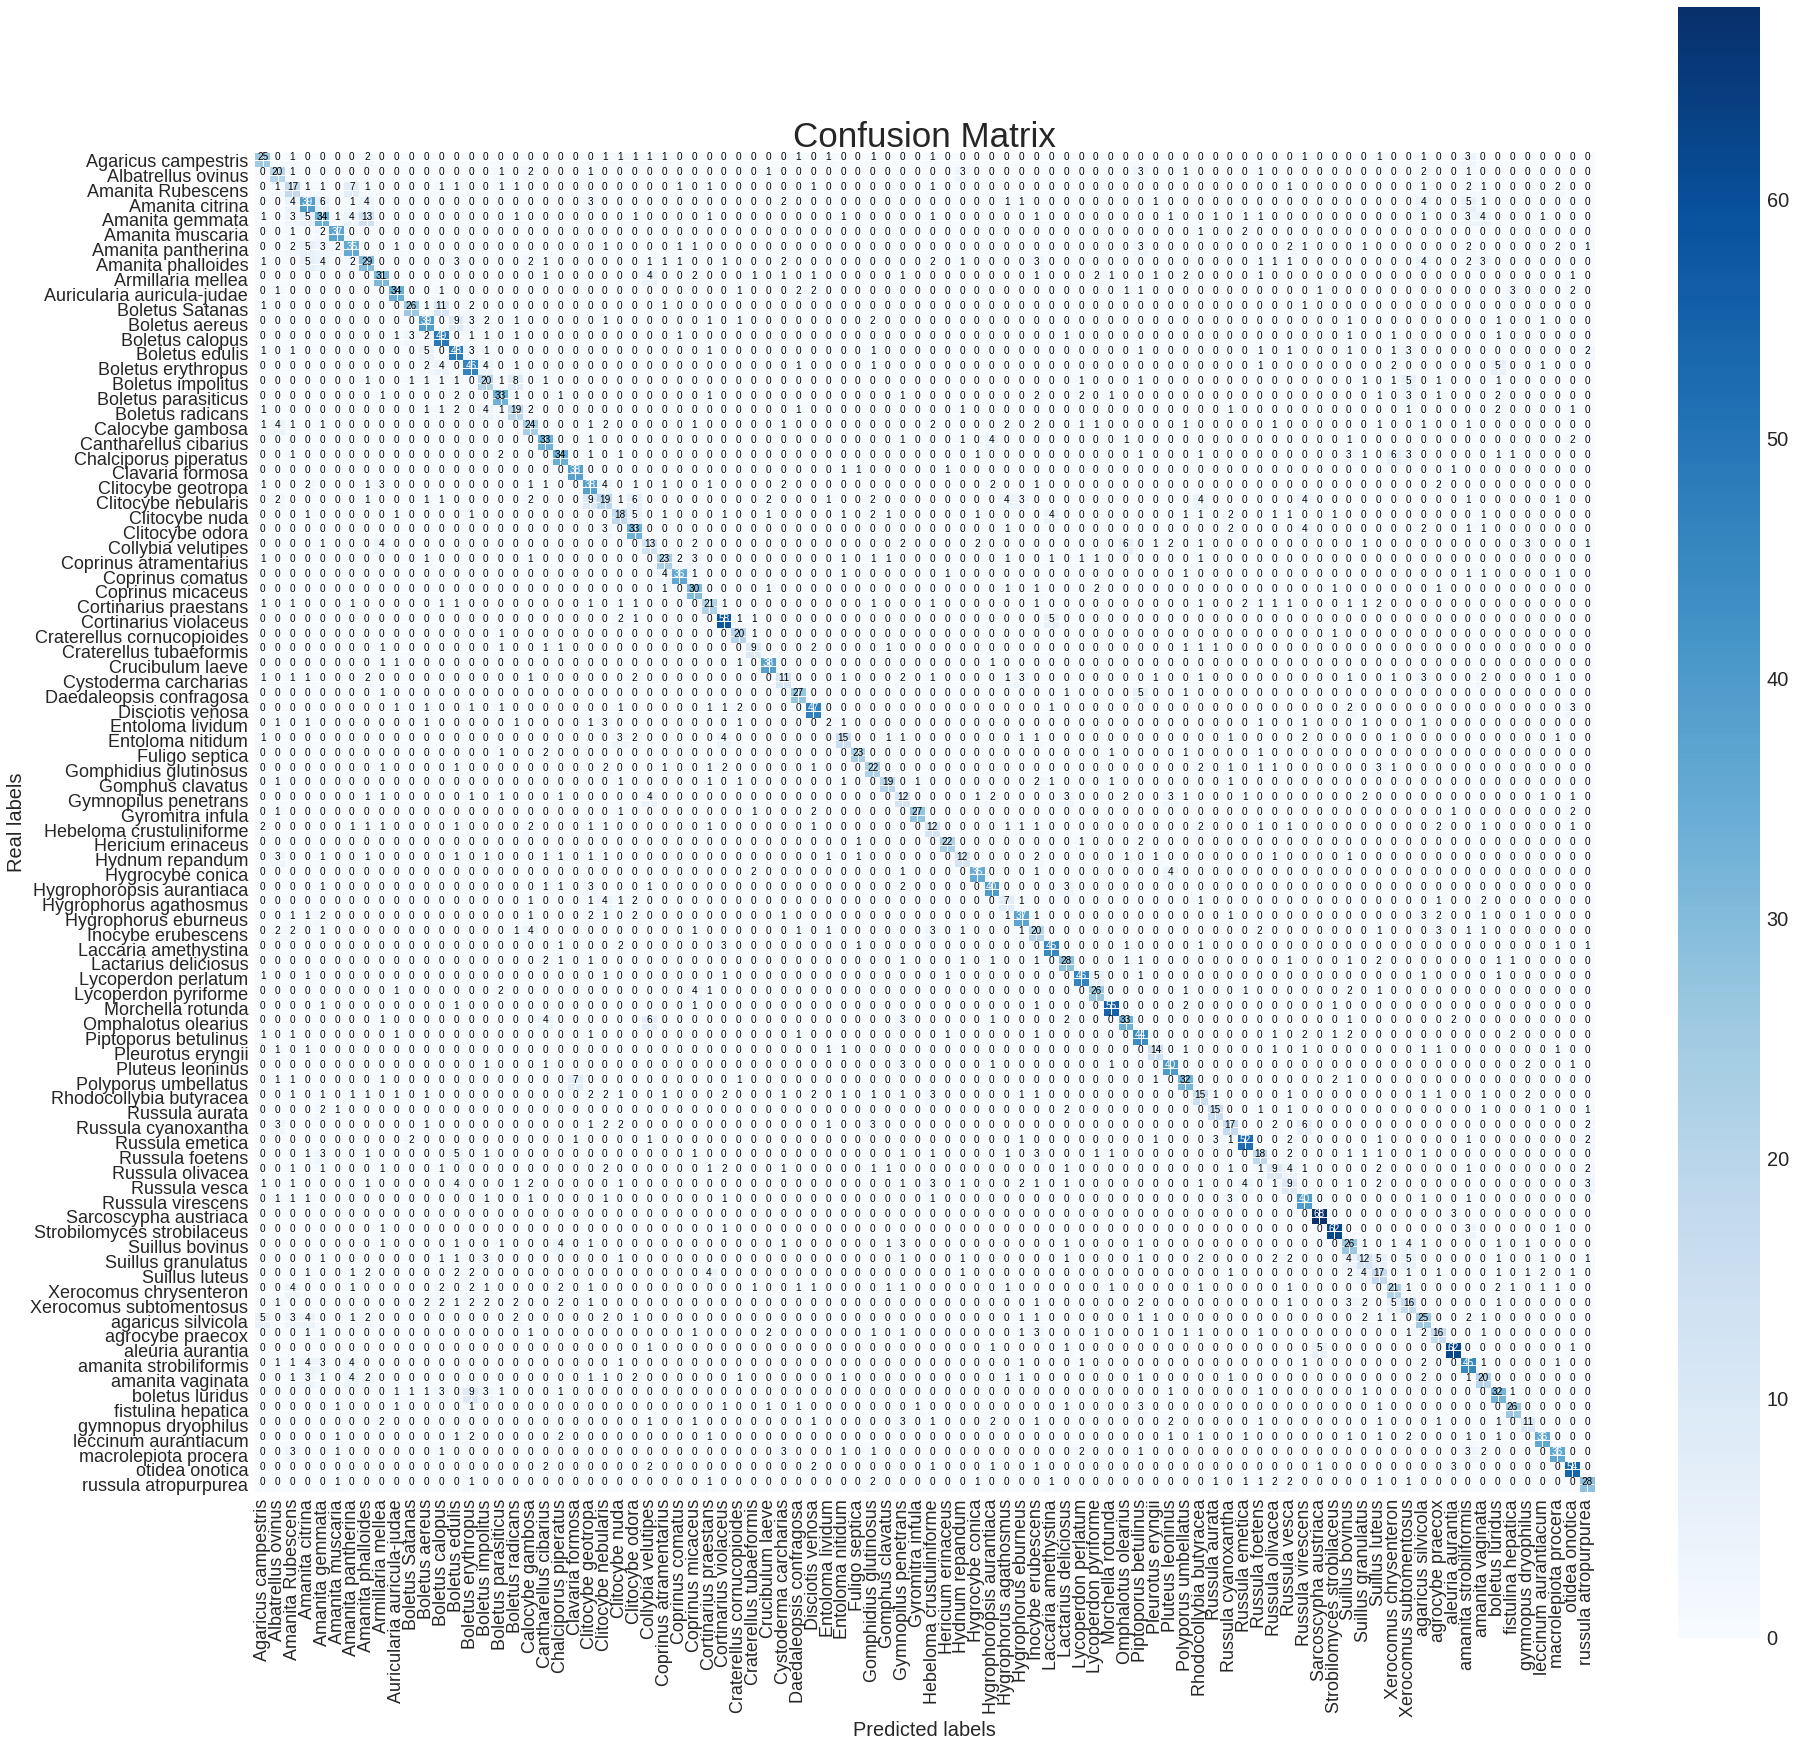

In [30]:
from sklearn.metrics import confusion_matrix
import itertools


def cf(y_test, prediction):
    cnf_matrix = confusion_matrix(y_test, prediction)
    classes= np.unique(y_test)

    plt.figure(figsize=(30,30))

    plt.imshow(cnf_matrix, interpolation='nearest',cmap='Blues')
    plt.title("Confusion Matrix", fontsize=35)
    cb = plt.colorbar()
    cb.ax.tick_params(labelsize=20)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)
    for i, j in itertools.product(range(cnf_matrix.shape[0]),
                                  range(cnf_matrix.shape[1])):
        plt.text(j, i, cnf_matrix[i, j],
                 horizontalalignment="center",
                 color="white" if cnf_matrix[i, j] > ( cnf_matrix.max() / 2) else "black")
    plt.ylabel('Real labels', fontsize=20)
    plt.xlabel('Predicted labels', fontsize=20)
    plt.xticks(rotation=90)

    plt.tick_params(axis = 'both', which = 'major', labelsize = 18)
    plt.show();
    

cf(y_test_v, pred_v)


In [0]:
crosstab = pd.crosstab(y_test_v, pred_v, rownames=['Classe réelles'], colnames=['Classe prédites'])

## Prediction by class

In [0]:
list_prediction_class = np.diag(crosstab)/crosstab.sum(axis=1)

In [0]:
list_prediction_class = list_prediction_class.sort_values(ascending=False)

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


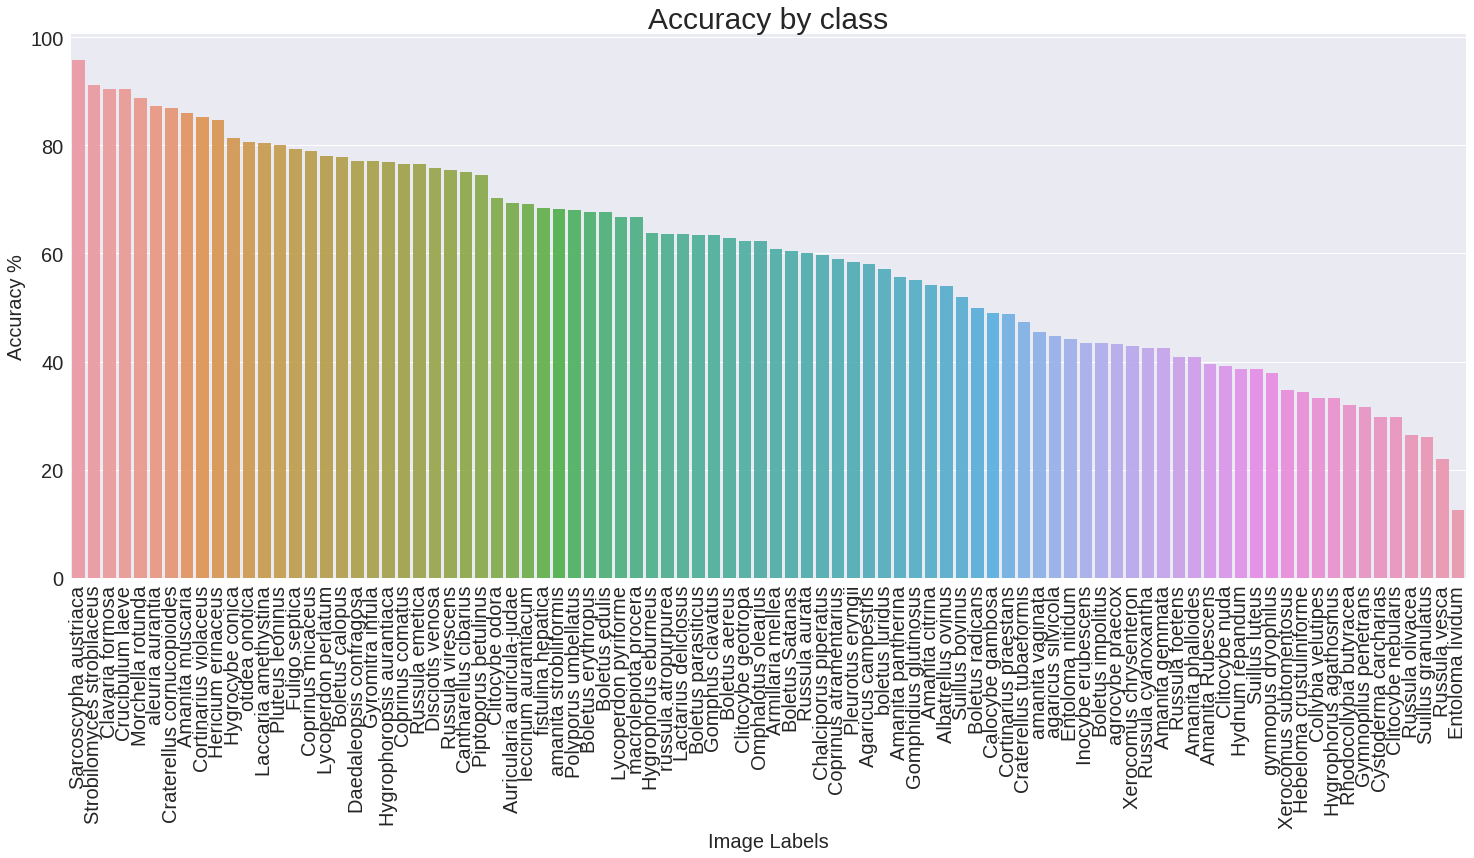

In [57]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize = (25,10))
sns.barplot(list_prediction_class.index, list_prediction_class.values*100, alpha = 0.9)
plt.title('Accuracy by class', fontsize=30)
plt.xticks(rotation = 'vertical')
plt.xlabel('Image Labels', fontsize =20)
plt.ylabel('Accuracy %', fontsize = 20)
plt.tick_params(axis = 'both', which = 'major', labelsize = 20)
plt.show();

## Missclassified mushrooms

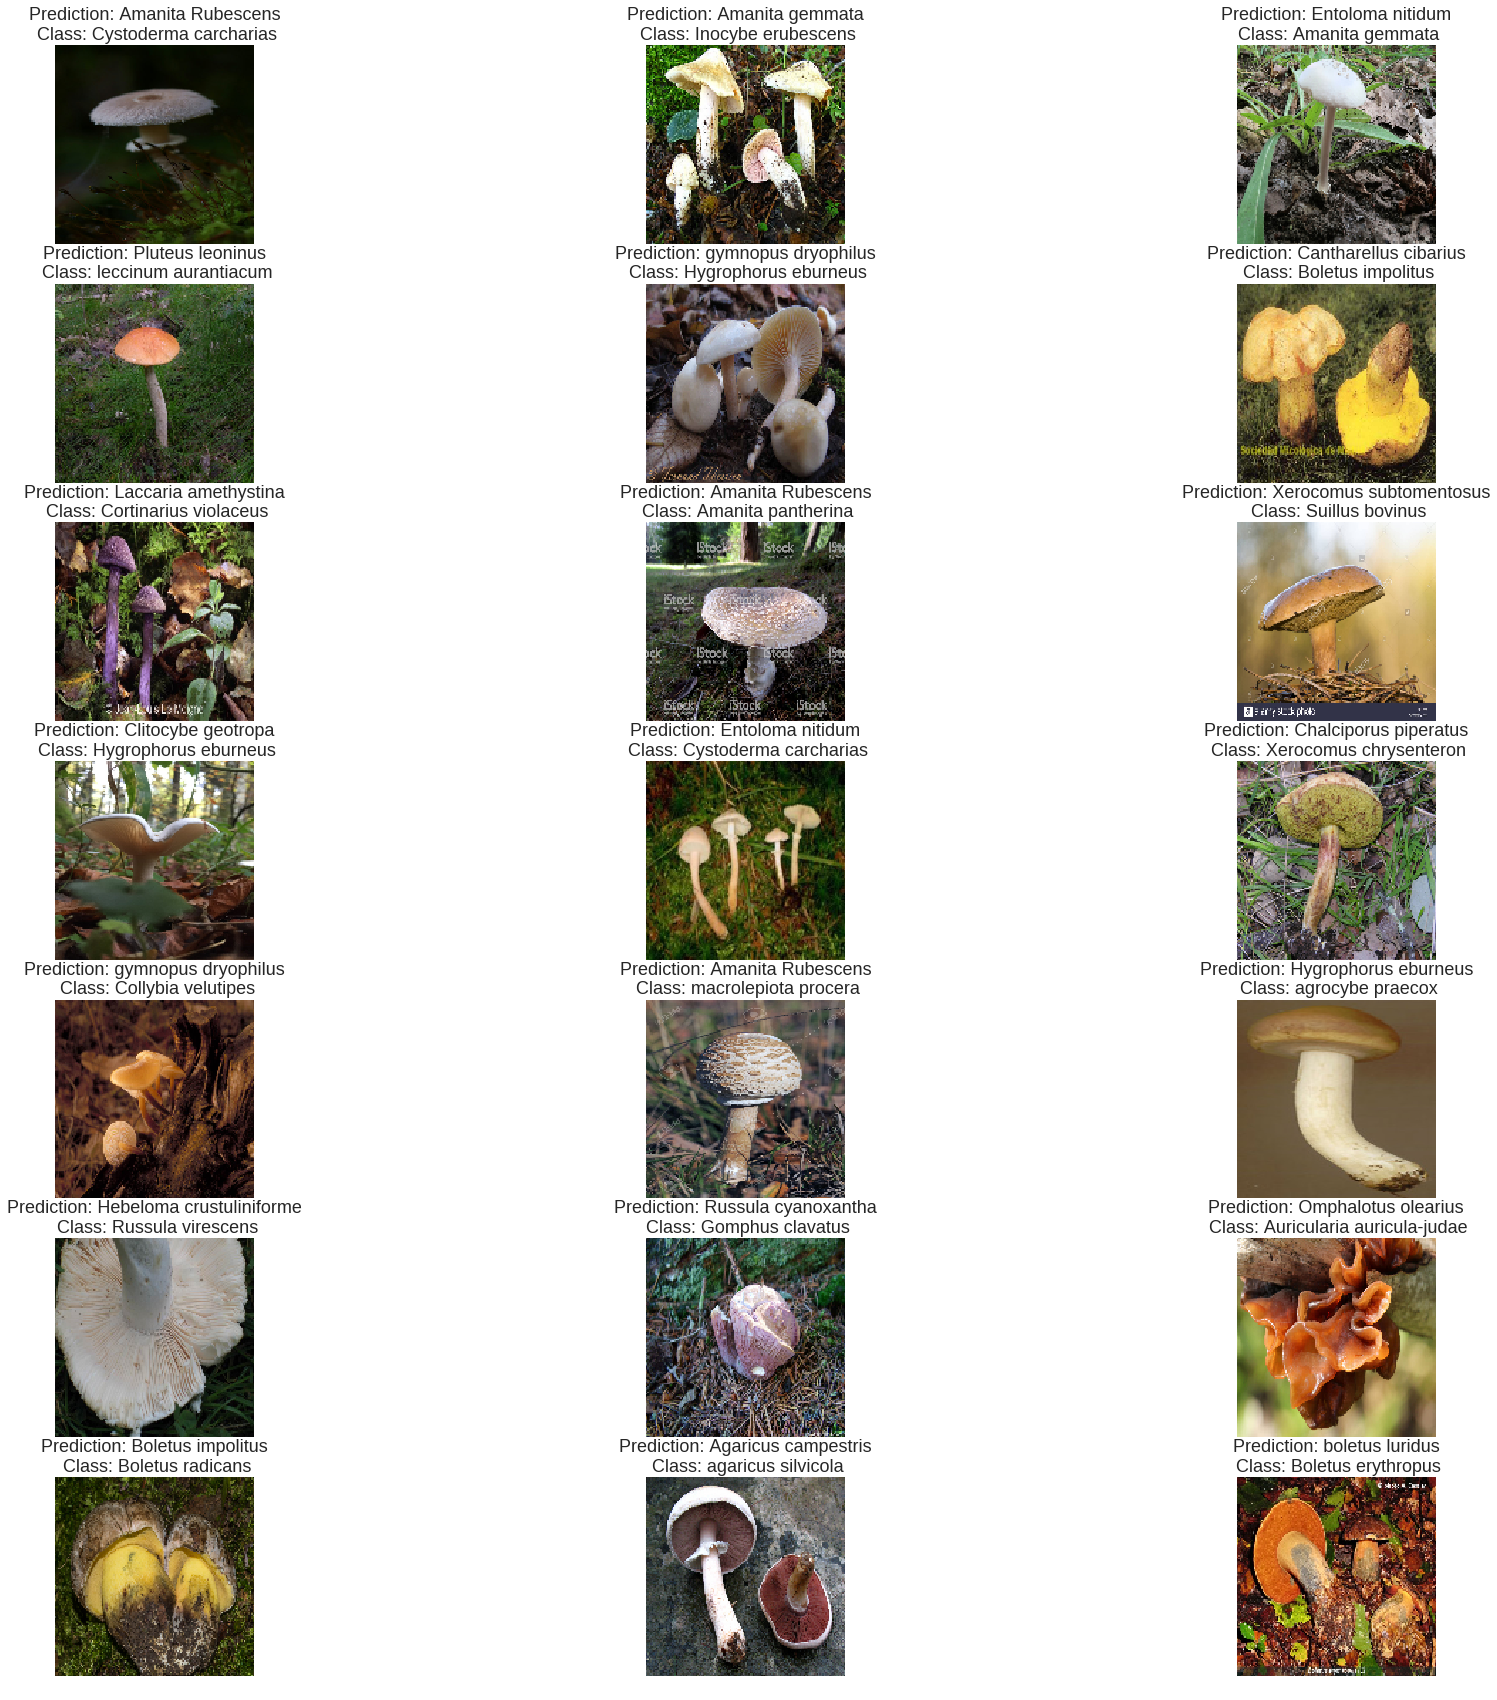

In [59]:
from matplotlib import cm
j=0
plt.figure(figsize=(30,30))
for i in np.random.choice(np.where(y_test_v!=pred_v)[0], size=21) :
    j=j+1
    img = X_test[i,:] 
    img = img.reshape(140,140,3)
    
    plt.subplot(7,3,j)
    plt.axis('off')
    plt.imshow(img,cmap = cm.binary)
    plt.title('Prediction: {predict}\n Class: {test}'.format(predict=pred_v[i], test=y_test_v[i]), fontsize=18)
